# NN & Node2Vec for Vote Prediction Only

This notebook trains two **non‑GNN models**: a simple **Neural Network (VoteNN)** and a **Node2Vec‑based model (VoteNode2Vec)** to predict, for a pair *(voter u, candidate t)*:

- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`



In [37]:
# Import standard libraries
import sys
from pathlib import Path
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Computations
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import Node2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from dataset import WikiRfAPreprocessor, train_val_test_split_by_date
from training import FocalLoss, train_polarity_only, eval_polarity
from utility import plot_cm

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_PATH = "checkpoints/votenn.pt"

print("DEVICE:", DEVICE)


ImportError: cannot import name 'plot_cm' from 'utility' (C:\Users\lucal\Desktop\università\LFN\hw_updated\LFN_assignment\utility.py)

In [ ]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

users = sorted(set([s[0] for s in preprocessed_RfA.samples] +
                   [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

X, y, dates = [], [], []
for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# {-1,0,1} → {0,1,2}
y_pos = y + 1


Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

In [ ]:
(X_tr, y_tr, dates_tr), \
(X_val, y_val, dates_val), \
(X_test, y_test, dates_test) = train_val_test_split_by_date(X, y_pos, dates)

print("Train:", X_tr.shape, dates_tr.min(), dates_tr.max())
print("Val:", X_val.shape, dates_val.min(), dates_val.max())
print("Test:", X_test.shape, dates_test.min(), dates_test.max())


Train: torch.Size([180838, 2]) 20030816 20120603
Val: torch.Size([4139, 2]) 20120609 20121204
Test: torch.Size([3839, 2]) 20121212 20130605


In [ ]:
pol_counts = torch.bincount(y_tr, minlength=3).float()
pol_base_w = pol_counts.sum() / pol_counts
pol_weights = pol_base_w.pow(0.5).to(DEVICE)


In [ ]:
num_users = len(user_map)
edge_index = X.t().contiguous()

data = HeteroData()
data['user'].x = torch.zeros((num_users, 1))  # dummy features

data['user','votes','user'].edge_index = edge_index
data['user','rev_votes','user'].edge_index = edge_index.flip(0)

data = data.to(DEVICE)


In [ ]:
edge_type = ('user','votes','user')

def add_edge_label_to_batch(batch):
    if hasattr(batch[edge_type], 'edge_label'):
        batch.edge_label = batch[edge_type].edge_label
    return batch

train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100,50],
    edge_label_index=(edge_type, X_tr.t().contiguous()),
    edge_label=y_tr,
    batch_size=2048,
    shuffle=True,
    transform=add_edge_label_to_batch
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100,50],
    edge_label_index=(edge_type, X_val.t().contiguous()),
    edge_label=y_val,
    batch_size=4096,
    shuffle=False,
    transform=add_edge_label_to_batch
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100,50],
    edge_label_index=(edge_type, X_test.t().contiguous()),
    edge_label=y_test,
    batch_size=4096,
    shuffle=False,
    transform=add_edge_label_to_batch
)


### VoteNN

A simple neural baseline that predicts vote polarity using only learned user embeddings.

Each user is assigned a trainable embedding vector of size `emb_dim`.  
For a vote `(src_user, tgt_user)`, the model:

1. looks up the embedding of the voter (`src`)  
2. looks up the embedding of the candidate (`tgt`)  
3. concatenates the two embeddings  
4. feeds the result into a small MLP  
5. outputs a 3‑class polarity prediction (`Oppose`, `Neutral`, `Support`)

This model does not use graph structure or message passing; it relies solely on the identity of the two users involved in the vote.


In [ ]:
class VoteNN(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        src = self.emb(x[:,0])
        tgt = self.emb(x[:,1])
        return self.mlp(torch.cat([src, tgt], dim=1))


### Train Node2Vec

We pre-train Node2Vec embeddings on the directed user–user voting graph built from the **training split only**.  
Each user is treated as a node, and each vote `(src → tgt)` becomes a directed edge.

Node2Vec performs biased random walks to learn structural embeddings that capture:

- voting patterns  
- user similarity  
- local graph neighborhoods  

The model is trained with negative sampling for several epochs.  
After training, we extract the learned embedding matrix `emb_node2vec`, which will be used as input features for the VoteNode2Vec classifier.


In [ ]:
# Train Node2Vec
G = nx.DiGraph()
for src, tgt in X_tr.numpy():
    G.add_edge(src, tgt)

edge_index_train = torch.tensor(np.array(G.edges()).T, dtype=torch.long)

node2vec = Node2Vec(
    edge_index_train,
    embedding_dim=64,
    walk_length=80,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    sparse=True,
    num_nodes=num_users
).to(DEVICE)

loader_n2v = node2vec.loader(batch_size=128, shuffle=True)
opt_n2v = torch.optim.SparseAdam(node2vec.parameters(), lr=0.01)

for epoch in range(1, 15):
    total = 0
    for pos_rw, neg_rw in loader_n2v:
        opt_n2v.zero_grad()
        loss_n2v = node2vec.loss(pos_rw.to(DEVICE), neg_rw.to(DEVICE))
        loss_n2v.backward()
        opt_n2v.step()
        total += loss_n2v.item()
    print(f"[Node2Vec] Epoch {epoch}, Loss {total:.4f}")

emb_node2vec = node2vec.embedding.weight.data


[Node2Vec] Epoch 1, Loss 214.1750
[Node2Vec] Epoch 2, Loss 97.9023
[Node2Vec] Epoch 3, Loss 71.7490
[Node2Vec] Epoch 4, Loss 66.4350
[Node2Vec] Epoch 5, Loss 64.8507
[Node2Vec] Epoch 6, Loss 64.1785
[Node2Vec] Epoch 7, Loss 63.8420
[Node2Vec] Epoch 8, Loss 63.6631
[Node2Vec] Epoch 9, Loss 63.5293
[Node2Vec] Epoch 10, Loss 63.4360
[Node2Vec] Epoch 11, Loss 63.3919
[Node2Vec] Epoch 12, Loss 63.3482
[Node2Vec] Epoch 13, Loss 63.3223
[Node2Vec] Epoch 14, Loss 63.2879


### VoteNode2Vec

A neural baseline that uses **pre‑trained Node2Vec embeddings** instead of learned user embeddings.

Node2Vec is first trained on the directed voting graph to capture structural patterns such as:
- user similarity  
- shared neighborhoods  
- voting communities  

The resulting embedding matrix is loaded into the model and kept trainable.

For each vote `(src_user, tgt_user)`, the model:

1. retrieves the Node2Vec embedding of the voter (`src`)
2. retrieves the Node2Vec embedding of the candidate (`tgt`)
3. concatenates the two embeddings
4. feeds the result into a small MLP
5. outputs a 3‑class polarity prediction (`Oppose`, `Neutral`, `Support`)

This model incorporates **graph structure indirectly** through Node2Vec, but does not perform message passing.


In [ ]:
class VoteNode2Vec(nn.Module):
    def __init__(self, emb_matrix, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(emb_matrix, freeze=False)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        src = self.emb(x[:,0])
        tgt = self.emb(x[:,1])
        return self.mlp(torch.cat([src, tgt], dim=1))


### ModelAdapter

A wrapper that adapts PyG mini‑batches to the input format expected by the NN and Node2Vec models.

`LinkNeighborLoader` produces batches where node IDs are **local indices** referring to the sampled subgraph.  
However, the NN and Node2Vec models require **global user IDs** to look up the correct embeddings.

The adapter performs the necessary mapping:

1. reads the local‑to‑global mapping `batch['user'].n_id`
2. extracts the local `(src, tgt)` indices from `edge_label_index`
3. converts them into global user IDs
4. builds a tensor `[src_global, tgt_global]`
5. forwards it to the underlying base model

This allows NN and Node2Vec to be trained using the **same neighbor‑sampling pipeline** as the GNN.


In [ ]:
class ModelAdapter(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, batch):
        # local ID → global ID
        n_id = batch['user'].n_id

        # edge_label_index contains local ID
        src_local, tgt_local = batch[('user','votes','user')].edge_label_index

        src = n_id[src_local]
        tgt = n_id[tgt_local]

        x = torch.stack([src, tgt], dim=1)
        return self.base_model(x)


In [ ]:
base_nn = VoteNN(num_users).to(DEVICE)
model_nn = ModelAdapter(base_nn).to(DEVICE)

opt_nn = torch.optim.Adam(model_nn.parameters(), lr=0.001, weight_decay=1e-4)
loss = FocalLoss(weight=pol_weights, gamma=1.0)

model_nn = train_polarity_only(
    model_nn, opt_nn, loss,
    train_loader, val_loader,
    device=DEVICE,
    patience=5,
    num_epochs=50,
    checkpoint_path=CHECKPOINT_PATH
)


Epoch 00 | Loss(avg): 1.2247 | Val macro-F1: 0.3235
Epoch 01 | Loss(avg): 1.1714 | Val macro-F1: 0.3367
Epoch 02 | Loss(avg): 1.0965 | Val macro-F1: 0.3613
Epoch 03 | Loss(avg): 1.0222 | Val macro-F1: 0.3837
Epoch 04 | Loss(avg): 0.9595 | Val macro-F1: 0.3857
Epoch 05 | Loss(avg): 0.9091 | Val macro-F1: 0.3848
Epoch 06 | Loss(avg): 0.8673 | Val macro-F1: 0.3852
Epoch 07 | Loss(avg): 0.8348 | Val macro-F1: 0.3707
Epoch 08 | Loss(avg): 0.8048 | Val macro-F1: 0.3658
Epoch 09 | Loss(avg): 0.7786 | Val macro-F1: 0.3685
Early stopping. Best Val macro-F1: 0.3857
Loaded best model with F1: 0.3857


In [ ]:
ckpt_n2v = "checkpoints/voten2v_best.pt"

base_n2v = VoteNode2Vec(emb_node2vec).to(DEVICE)
model_n2v = ModelAdapter(base_n2v).to(DEVICE)

opt_n2v = torch.optim.Adam(model_n2v.parameters(), lr=0.001, weight_decay=1e-4)

model_n2v = train_polarity_only(
    model_n2v, opt_n2v, loss,
    train_loader, val_loader,
    device=DEVICE,
    patience=5,
    num_epochs=50,
    checkpoint_path=ckpt_n2v
)


Epoch 00 | Loss(avg): 1.1972 | Val macro-F1: 0.2154
Epoch 01 | Loss(avg): 0.9113 | Val macro-F1: 0.2204
Epoch 02 | Loss(avg): 0.8171 | Val macro-F1: 0.2705
Epoch 03 | Loss(avg): 0.7649 | Val macro-F1: 0.3017
Epoch 04 | Loss(avg): 0.7308 | Val macro-F1: 0.3196
Epoch 05 | Loss(avg): 0.7074 | Val macro-F1: 0.3243
Epoch 06 | Loss(avg): 0.6880 | Val macro-F1: 0.3270
Epoch 07 | Loss(avg): 0.6713 | Val macro-F1: 0.3234
Epoch 08 | Loss(avg): 0.6570 | Val macro-F1: 0.3248
Epoch 09 | Loss(avg): 0.6407 | Val macro-F1: 0.3314
Epoch 10 | Loss(avg): 0.6240 | Val macro-F1: 0.3396
Epoch 11 | Loss(avg): 0.6078 | Val macro-F1: 0.3444
Epoch 12 | Loss(avg): 0.5887 | Val macro-F1: 0.3574
Epoch 13 | Loss(avg): 0.5671 | Val macro-F1: 0.3584
Epoch 14 | Loss(avg): 0.5448 | Val macro-F1: 0.3551
Epoch 15 | Loss(avg): 0.5231 | Val macro-F1: 0.3671
Epoch 16 | Loss(avg): 0.4976 | Val macro-F1: 0.3619
Epoch 17 | Loss(avg): 0.4722 | Val macro-F1: 0.3664
Epoch 18 | Loss(avg): 0.4465 | Val macro-F1: 0.3741
Epoch 19 | L

NN macro-F1: 0.32162828174950603
              precision    recall  f1-score   support

      Oppose       0.19      0.39      0.26       725
     Neutral       0.06      0.04      0.05       219
     Support       0.75      0.58      0.65      2895

    accuracy                           0.51      3839
   macro avg       0.34      0.34      0.32      3839
weighted avg       0.61      0.51      0.55      3839



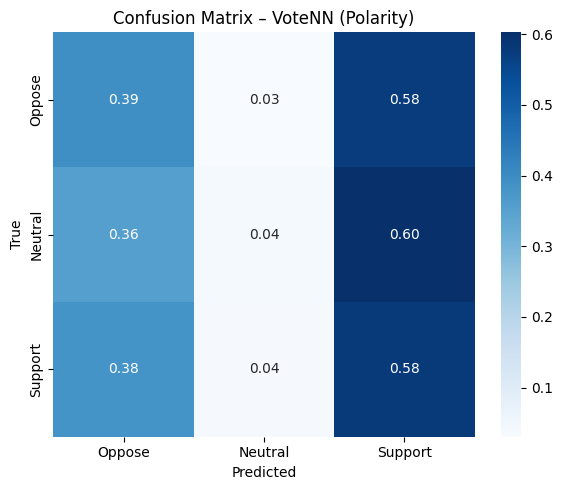

In [ ]:
# Evaluate NN
test_f1, (y_true, y_pred), report = eval_polarity(model_nn, test_loader, DEVICE, report=True)
print("NN macro-F1:", test_f1)
print(report)

# Confusion matrix
cm_nn = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plot_cm(cm_nn, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix – VoteNN (Polarity)", normalize=True)


Node2Vec macro-F1: 0.3638758175915912
              precision    recall  f1-score   support

      Oppose       0.25      0.32      0.28       725
     Neutral       0.07      0.10      0.08       219
     Support       0.78      0.69      0.73      2895

    accuracy                           0.59      3839
   macro avg       0.36      0.37      0.36      3839
weighted avg       0.64      0.59      0.61      3839



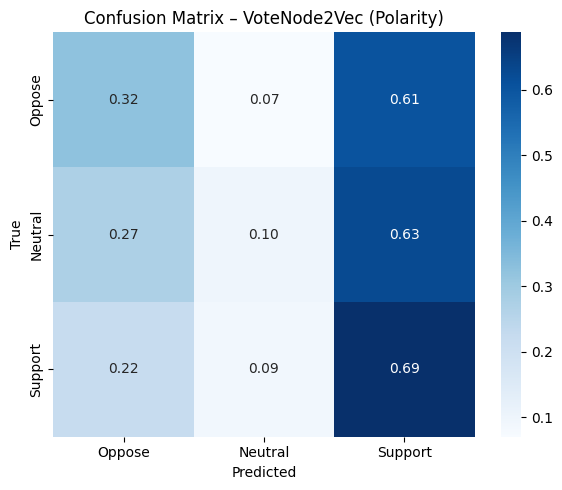

In [ ]:
# Evaluate Node2Vec
test_f1, (y_true, y_pred), report = eval_polarity(model_n2v, test_loader, DEVICE, report=True)
print("Node2Vec macro-F1:", test_f1)
print(report)

# Confusion matrix
cm_n2v = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plot_cm(cm_n2v, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix – VoteNode2Vec (Polarity)", normalize=True)
